<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9D%D0%B5%D0%BF%D1%80%D0%B5%D1%80%D1%8B%D0%B2%D0%BD%D0%BE%D0%B5_%D0%B2%D0%BD%D1%83%D1%82%D1%80%D0%B5%D0%BD%D0%BD%D0%B5%D0%B5_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%82%D0%B2%D0%BE_%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_%D0%92%D0%BE%D0%B7%D0%BD%D0%B8%D0%BA%D0%BD%D0%BE%D0%B2%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%A0%D0%B0%D0%B7%D0%B1%D0%BE%D1%80_%D0%B4_%D0%B7_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ООО "Университет Цифровых Технологий платформа 3"

# Непрерывное внутреннее пространство. Вариационные автокодировщики. Возникновение генерации данных. - Разбор д.з.

# Вариационный автокодировщик


Импортируем библиотеки

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import clear_output 
import numpy as np
%matplotlib inline
from time import time
import tqdm

## Оставляем только код, который планируем использовать

Слой Sampling

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


Класс вариационный автокодировщик

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Загрузим датасет MNIST, преобразуем данные в тип float32 в диапазоне от 0 до 1:

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11493376/11490434 [==============================] - 0s 0us/step


Функция вывода картинок

In [ ]:
def plotImages(y, pred, n=6, figsize=(16,4)): 
    plt.figure(figsize=figsize) 
    for i in range(n): 
        index = np.random.randint(0, pred.shape[0]) # выбираем картинки случайно
        # Показываем исходные картинки
        ax = plt.subplot(2, n, i + 1) 
        plt.imshow(y[index].squeeze(axis=-1), cmap='gray') 
        # Показываем восстановленные картинки
        ax = plt.subplot(2, n, i + 1 + n)  
        plt.imshow(pred[index].squeeze(axis=-1), cmap='gray')     
    plt.show()

# Домашнее задание


## Базовый

Используя VAE из занятия, рассмотреть различные размерности скрытого пространства - 2, 10, 100. Сравнить результаты.

Повторяем ячейки для VAE из занятия, положив latent_dim=10:

In [ ]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              34496     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 90,177
Trainable params: 90,177
Non-trainable params: 0
_______________________________________________________

In [ ]:
%%time
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 38s 9ms/step - loss: 247.9345 - reconstruction_loss: 195.7439 - kl_loss: 6.4967
Epoch 2/30
547/547 [==============================] - 5s 9ms/step - loss: 158.0587 - reconstruction_loss: 140.9975 - kl_loss: 11.1029
Epoch 3/30
547/547 [==============================] - 5s 9ms/step - loss: 142.8740 - reconstruction_loss: 130.7423 - kl_loss: 11.2674
Epoch 4/30
547/547 [==============================] - 5s 9ms/step - loss: 139.2619 - reconstruction_loss: 127.4855 - kl_loss: 11.1316
Epoch 5/30
547/547 [==============================] - 5s 9ms/step - loss: 137.1352 - reconstruction_loss: 125.5733 - kl_loss: 11.0856
Epoch 6/30
547/547 [==============================] - 5s 9ms/step - loss: 135.4840 - reconstruction_loss: 124.2338 - kl_loss: 11.1079
Epoch 7/30
547/547 [==============================] - 5s 9ms/step - loss: 134.5555 - reconstruction_loss: 123.1675 - kl_loss: 11.0567
Epoch 8/30
547/547 [==============================] - 5s 9ms/s

Для сравнения выводим образцы восстановления изображений. (Необходимо выполнить некоторые ячейки из урока)

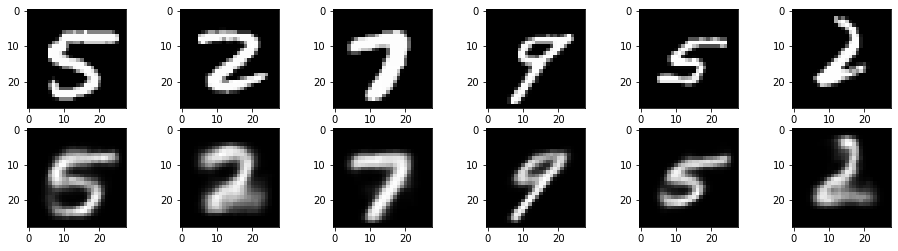

In [ ]:
(_, _), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = np.expand_dims(x_test, -1).astype("float32") / 255
_, _, z_test = vae.encoder.predict(x_test)
pred = decoder.predict(z_test)
plotImages(x_test, pred)

Основной вывод - увеличение размерности скрытого пространства способствует более точному восстановлению.

## Основной

Сравнить 2 варианта VAE - на основе полносвязной и сверточной сетей. 

РЕШЕНИЕ:

Для получения VAE на основе полносвязных сетей просто заменяем сверточные слои в энкодере и декодере на Dense-слой:

In [ ]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs) # Необходимо развернуть изображение в вектор для dense-слоя
x = layers.Dense(800, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 800)          628000      flatten_2[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           8010        dense_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(800, activation="relu")(latent_inputs)
x = layers.Dense(28*28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 800)               8800      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               627984    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 636,784
Trainable params: 636,784
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 2s 3ms/step - loss: 196.8357 - reconstruction_loss: 136.8895 - kl_loss: 15.8974
Epoch 2/30
547/547 [==============================] - 2s 3ms/step - loss: 123.6427 - reconstruction_loss: 104.9052 - kl_loss: 16.9272
Epoch 3/30
547/547 [==============================] - 2s 3ms/step - loss: 118.0312 - reconstruction_loss: 99.8323 - kl_loss: 17.4148
Epoch 4/30
547/547 [==============================] - 2s 3ms/step - loss: 115.1166 - reconstruction_loss: 97.1251 - kl_loss: 17.7698
Epoch 5/30
547/547 [==============================] - 2s 3ms/step - loss: 113.4046 - reconstruction_loss: 95.2021 - kl_loss: 18.0006
Epoch 6/30
547/547 [==============================] - 2s 3ms/step - loss: 112.2426 - reconstruction_loss: 93.7806 - kl_loss: 18.1908
Epoch 7/30
547/547 [==============================] - 2s 3ms/step - loss: 110.8984 - reconstruction_loss: 92.6459 - kl_loss: 18.3359
Epoch 8/30
547/547 [==============================] - 2s 3ms/step -

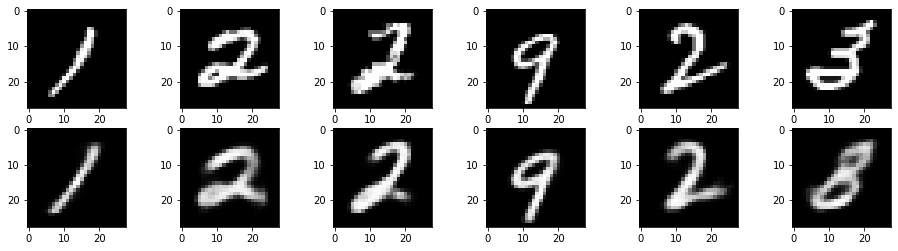

In [ ]:
_, _, z_test = vae.encoder.predict(x_test)
pred = decoder.predict(z_test)
plotImages(x_test, pred)

## Продвинутый

Сделать генерацию изображений с помощью VAE для лиц

In [ ]:
!wget https://xland.ru/datasets/faces.tgz

--2021-05-19 05:17:42--  https://xland.ru/datasets/faces.tgz
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40742625 (39M) [application/x-gzip]
Saving to: ‘faces.tgz’

faces.tgz           100%[===================>]  38.85M  24.4MB/s    in 1.6s    

2021-05-19 05:17:44 (24.4 MB/s) - ‘faces.tgz’ saved [40742625/40742625]



In [ ]:
!tar xfz faces.tgz

In [ ]:
img_dir = 'faces'
img_h = 176
img_w = 144

Функция для чтения jpg файлов и преобразования в массив.

In [ ]:
def load_images(dir, height=img_h, width=img_w):
    img_list = []
    for file in sorted(os.listdir(img_dir)):
        path = os.path.join(img_dir, file)
        img = image.load_img(path)
        img = img.resize((img_w, img_h))
        arr = image.img_to_array(img)
        img_list.append(arr)
    return np.array(img_list)

In [ ]:
%%time
faces = load_images(img_dir)/255.

CPU times: user 9.47 s, sys: 2.3 s, total: 11.8 s
Wall time: 11.8 s


In [ ]:
faces.shape

(3358, 176, 144, 3)

Выведем образцы изображений

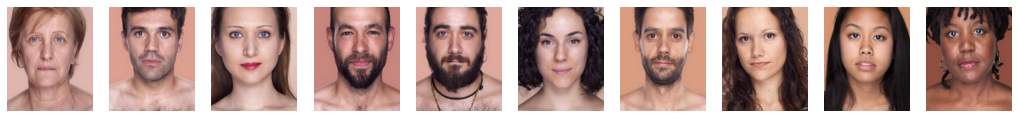

In [ ]:
plt.figure(figsize=(18,4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(faces[i])

In [ ]:
def plotFaces(y, pred, n=10, figsize=(18, 5)): 
    plt.figure(figsize=figsize) 
    for i in range(n): 
        index = np.random.randint(0, pred.shape[0]) # выбираем картинки случайно
        # Показываем исходные картинки
        ax = plt.subplot(2, n, i + 1) 
        plt.axis('off')
        plt.imshow(y[i]) 
        # Показываем восстановленные картинки
        ax = plt.subplot(2, n, i + 1 + n)  
        plt.axis('off')
        plt.imshow(pred[i])     
    plt.show()

In [ ]:
latent_dim = 100

encoder_inputs = keras.Input(shape=(176, 144, 3))

x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D()(x) # 88x72

x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D()(x) # 44x36

x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D()(x) # 22x18

x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D()(x) # 11x9

x = layers.Flatten()(x)
z = layers.Dense(latent_dim, activation="relu")(x)
# z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 144, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 176, 144, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 144, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 88, 72, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 88, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 36, 64)        0   

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(11 * 9 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((11, 9, 128))(x)

x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)

x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)

x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)

x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 12672)             1279872   
_________________________________________________________________
reshape (Reshape)            (None, 11, 9, 128)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 22, 18, 128)       147584    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 18, 128)       147584    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 18, 128)       147584    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 44, 36, 128)       1475

In [ ]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            total_loss = tf.reduce_mean(
                tf.reduce_mean(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
                ),
                axis=0
            )
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.total_loss_tracker.result(),
        }


Верхний ряд - исходные изображения, нижний - восстановленные.

In [ ]:
ae = AE(encoder, decoder) 

In [ ]:
%%time
ae.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error') 
history = ae.fit(faces, epochs=100, batch_size=128)

Epoch 1/100
27/27 [==============================] - 61s 783ms/step - loss: 0.0613
Epoch 2/100
27/27 [==============================] - 20s 723ms/step - loss: 0.0560
Epoch 3/100
27/27 [==============================] - 20s 743ms/step - loss: 0.0552
Epoch 4/100
27/27 [==============================] - 21s 766ms/step - loss: 0.0554
Epoch 5/100
27/27 [==============================] - 20s 757ms/step - loss: 0.0554
Epoch 6/100
27/27 [==============================] - 20s 749ms/step - loss: 0.0545
Epoch 7/100
27/27 [==============================] - 20s 746ms/step - loss: 0.0500
Epoch 8/100
27/27 [==============================] - 20s 749ms/step - loss: 0.0437
Epoch 9/100
27/27 [==============================] - 20s 749ms/step - loss: 0.0374
Epoch 10/100
27/27 [==============================] - 20s 746ms/step - loss: 0.0257
Epoch 11/100
27/27 [==============================] - 20s 748ms/step - loss: 0.0188
Epoch 12/100
27/27 [==============================] - 20s 748ms/step - loss: 0.0154
E

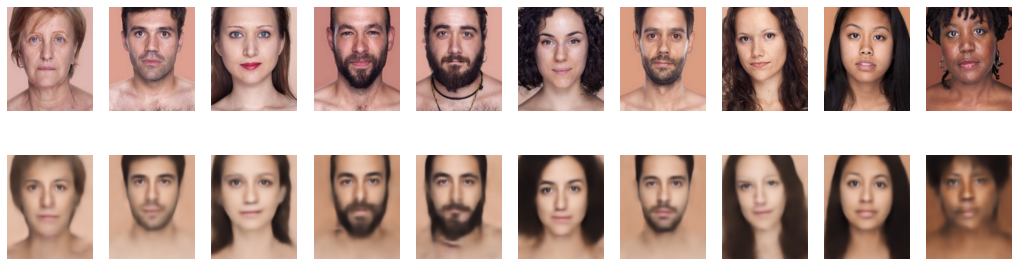

In [ ]:
z = ae.encoder(faces[:10])
pred = ae.decoder(z)
plotFaces(faces[:10], pred)

## Профи

Сделать генерацию изображений с помощью VAE на примере плавного перехода от одного лица к другому.

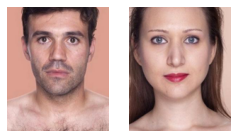

In [ ]:
plt.figure(figsize=(4, 3))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.axis('off')
    plt.imshow(faces[i + 1])

Попробуем плавно преобразовать одно лицо в другое, например лицо мужчины (№2) в женское (№3)

Сначала получим вектора z1 и z2 - представления этих лиц в скрытом пространстве:

In [ ]:
z1 = ae.encoder(faces[1:2]) # мужчина
z2 = ae.encoder(faces[2:3]) # девушка

сделаем последовательность из 11 векторов $ z = z_1(1 - \alpha) + z_2\alpha, 
\alpha = 0, 0.1, 0.2, ..., 1.0 $

Эти вектора будут представлять плавный переход от $z_1$ к $z_2$

In [ ]:
z = np.linspace(z1.numpy(), z2.numpy(), 11).reshape(11, 100)

Получим картинки, соответствующие векторам в z-пространстве: 

In [ ]:
pred = ae.decoder(z)

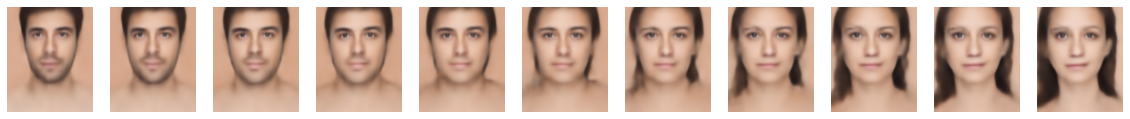

In [ ]:
plt.figure(figsize=(20, 3))
for i in range(11):
    plt.subplot(1, 11, i + 1)
    plt.axis('off')
    plt.imshow(pred[i])

#Литература

1. http://www.williamspublishing.com/PDF/978-5-907144-50-7/part.pdf
2. https://habr.com/ru/post/429276/
3. https://neurohive.io/ru/osnovy-data-science/variacionnyj-avtojenkoder-vae/
4. http://intsysjournal.org/articles/is2102/07.pdf
5. https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5
6. http://www.frccsc.ru/sites/default/files/docs/ds/002-073-05/diss/26-bahteev/ds05-26-bahteev_main.pdf?28
7. https://blog.keras.io/building-autoencoders-in-keras.html


# End